# House Prices - Advanced Regression Techniques 

# A. Data preprocessing and EDA
### Imports packages 

In [1]:
import os
import warnings

import time

# Start counting notebook running time
time_start = time.time()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Ridge, LinearRegression
from sklearn.ensemble import StackingRegressor

import optuna

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.set()

# Mute warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
# Train data
train = pd.read_csv("train.csv", index_col="Id")
print('train data size: ', train.shape)

# Test data
test = pd.read_csv("test.csv", index_col="Id")
print('test data size: ', test.shape)

train data size:  (1460, 80)
test data size:  (1459, 79)


In [3]:
pd.set_option('display.max_columns', None) 
train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
original_column_names = train.columns
original_column_names

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Check missing values (in percentage)

<Axes: ylabel='Missing values (%)'>

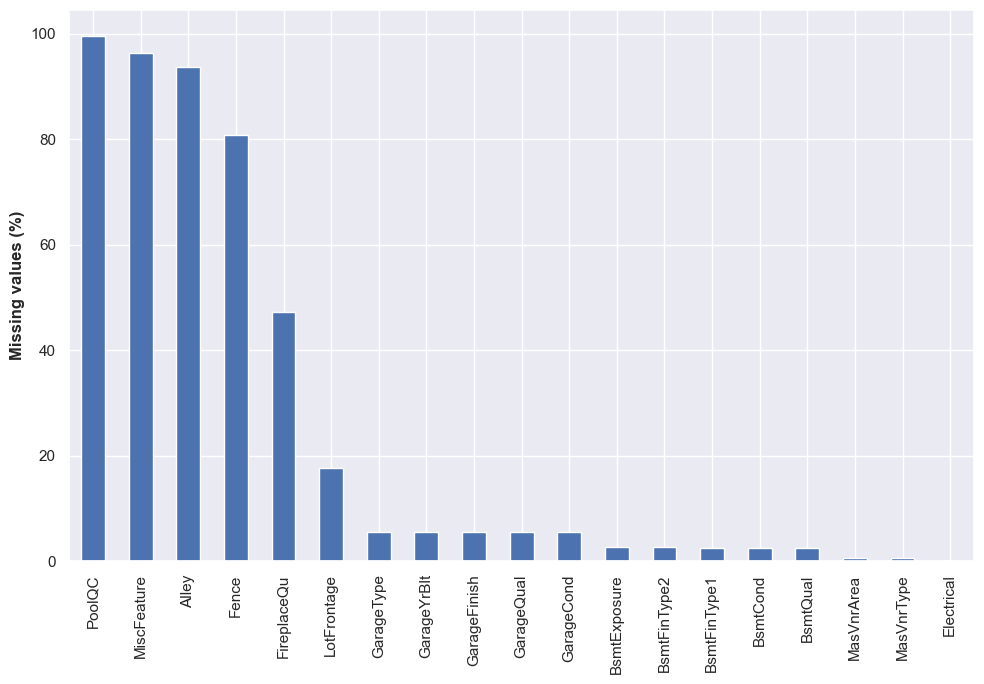

In [5]:
df_missing = train.isna().sum()[train.isna().sum() > 0].sort_values(ascending = False)/len(train)*100
df_missing.plot.bar(figsize = (10,7), ylabel = 'Missing values (%)')

### Define train and test data

In [6]:
X_train = train.copy()
y_train = X_train.pop("SalePrice")
X_test = test.copy()
print('train data size: ', X_train.shape)
print('test data size: ', X_test.shape)

train data size:  (1460, 79)
test data size:  (1459, 79)


### Re-name features

In [7]:
# Renaming some features
# Feature names beginning with numbers are awkward to work with, so we rename them
def rename_columns(df):
    X = df.copy()
    # Names beginning with numbers are awkward to work with
    X.rename(columns={"1stFlrSF": "FirstFlrSF",
                       "2ndFlrSF": "SecondFlrSF",
                       "3SsnPorch": "Threeseasonporch"},
              inplace=True)
    return X

X_train = rename_columns(X_train)

### Clean Data

Some of the categorical features in this dataset have what are apparently typos in their categories (as we compare them to the information in data_description.txt):

In [8]:
# Clean Data
def clean(df):
    X = df.copy()
    X["Exterior2nd"] = X["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them with the year the house was built
    X["GarageYrBlt"] = X["GarageYrBlt"].where(X.GarageYrBlt <= 2010, X.YearBuilt)
    
    # Some values of YrSold are also corrupt i.e. house was sold before it was built! We'll replace them with the year the house was built
    X["YrSold"] = X["YrSold"].where(X.YrSold >= X.YearBuilt, X.YearBuilt)
    
    return X

X_train = clean(X_train)

### Convert incorrect data type

In [9]:
# The 'MSSubClass' is a string/unordered(nominal) categorical variable but encoded as `int` type. So we need to convert the data type. 
other_categorical_features = ['MSSubClass'] 

def numer_to_object(df):
    X = df.copy()
    for name in other_categorical_features:
        X[name] = X[name].astype('str')
    return X

X_train = numer_to_object(X_train)

### Impute Missing Values

In [10]:
# Handle Missing Values
def impute(df):
    X = df.copy()
    for name in X.select_dtypes("number"):
        X[name] = X[name].fillna(0)
    for name in X.select_dtypes("object"):
        X[name] = X[name].fillna("None") 
    return X

# impute NAs
X_train = impute(X_train)

# Check if there are still NAs
print(X_train.isna().sum()[X_train.isna().sum() > 0].sort_values(ascending = False))

Series([], dtype: int64)


### Categorical features: ordinal encoding

In [11]:
# Some of the categorical features are ordered so we need to correctly encode them with specific orders

ordered_levels = {
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "PoolQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# add a new category 'None' in each ordinal categorical feature so that we can replace NAs with a category 'None'.
ordered_levels = {key: ["None"] + value for key, value in ordered_levels.items()} # the 1st level is 'None'

def ordinal_encode(df):
    X = df.copy()
    # Ordinal categories
    for name, levels in ordered_levels.items():
        X[name] = X[name].astype(CategoricalDtype(levels, ordered=True)) 
    return X

# encode ordered categorical features
X_train = ordinal_encode(X_train)

### Categorical features: nominal encoding

In [12]:
# # Identify the nominal (unordered) categorical features (assuming they are all object types)
# nominal_features = X_train.select_dtypes(include='object').columns

# # Create levels dictionary for all nominal features
# unordered_levels = {
#     feature: (["None"] + list(X_train[feature].unique())) if "None" not in X_train[feature].unique() else list(X_train[feature].unique())
#     for feature in nominal_features
# }
# print(unordered_levels)

In [13]:
unordered_levels = {'MSSubClass': ['None', '60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80', '160', '75', '180', '40'], 
          'MSZoning': ['None', 'RL', 'RM', 'C (all)', 'FV', 'RH'], 
          'Street': ['None', 'Pave', 'Grvl'], 
          'Alley': ['None', 'Grvl', 'Pave'], 
          'LandContour': ['None', 'Lvl', 'Bnk', 'Low', 'HLS'], 
          'LotConfig': ['None', 'Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], 
          'Neighborhood': ['None', 'CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst', 'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes', 'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert', 'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste'], 
          'Condition1': ['None', 'Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe'], 
          'Condition2': ['None', 'Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'], 
          'BldgType': ['None', '1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], 
          'HouseStyle': ['None', '2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin'], 
          'RoofStyle': ['None', 'Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], 
          'RoofMatl': ['None', 'CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv', 'Roll', 'ClyTile'], 
          'Exterior1st': ['None', 'VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing', 'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn', 'Stone', 'ImStucc', 'CBlock'], 
          'Exterior2nd': ['None', 'VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng', 'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'BrkComm', 'ImStucc', 'AsphShn', 'Stone', 'Other', 'CBlock'], 
          'MasVnrType': ['BrkFace', 'None', 'Stone', 'BrkCmn'], 
          'Foundation': ['None', 'PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], 
          'Heating': ['None', 'GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], 
          'GarageType': ['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'None', 'Basment', '2Types'], 
          'MiscFeature': ['None', 'Shed', 'Gar2', 'Othr', 'TenC'], 
          'SaleType': ['None', 'WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'], 
          'SaleCondition': ['None', 'Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family']}

def nominal_encode(df):
    X = df.copy()
    # Ordinal categories
    for name, levels in unordered_levels.items():
        X[name] = X[name].astype(CategoricalDtype(levels, ordered=False))
    return X

# encode nominal categorical features
X_train = nominal_encode(X_train)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

### Factorize ordered categorical features with label encoding

In [15]:
# Factorize ordered categorical features with label encoding
def label_encode(df):
    X = df.copy()
    # The `cat.codes` attribute holds the category levels.
    for colname in X.select_dtypes(["category"]).columns:
        if X[colname].cat.ordered:  # Check if the categorical column is ordered
            X[colname] = X[colname].cat.codes
    return X

X_train = label_encode(X_train)

We take care of the nominal categorical features after feature engineering. 

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   int8    
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   int8    
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   int8    
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

### Initial Analysis and Baseline Score

In [17]:
numeric_features = []
train_data = pd.concat([X_train, y_train], axis =1)
for feature in train_data.select_dtypes(["float64", "int64"]).drop('SalePrice', axis = 1): 
    numeric_features.append(feature)
    
print('number of numeric features: ', len(numeric_features))

number of numeric features:  35


The plot below helps to visually understand which numerical features have a strong relationship the label Saleproice.

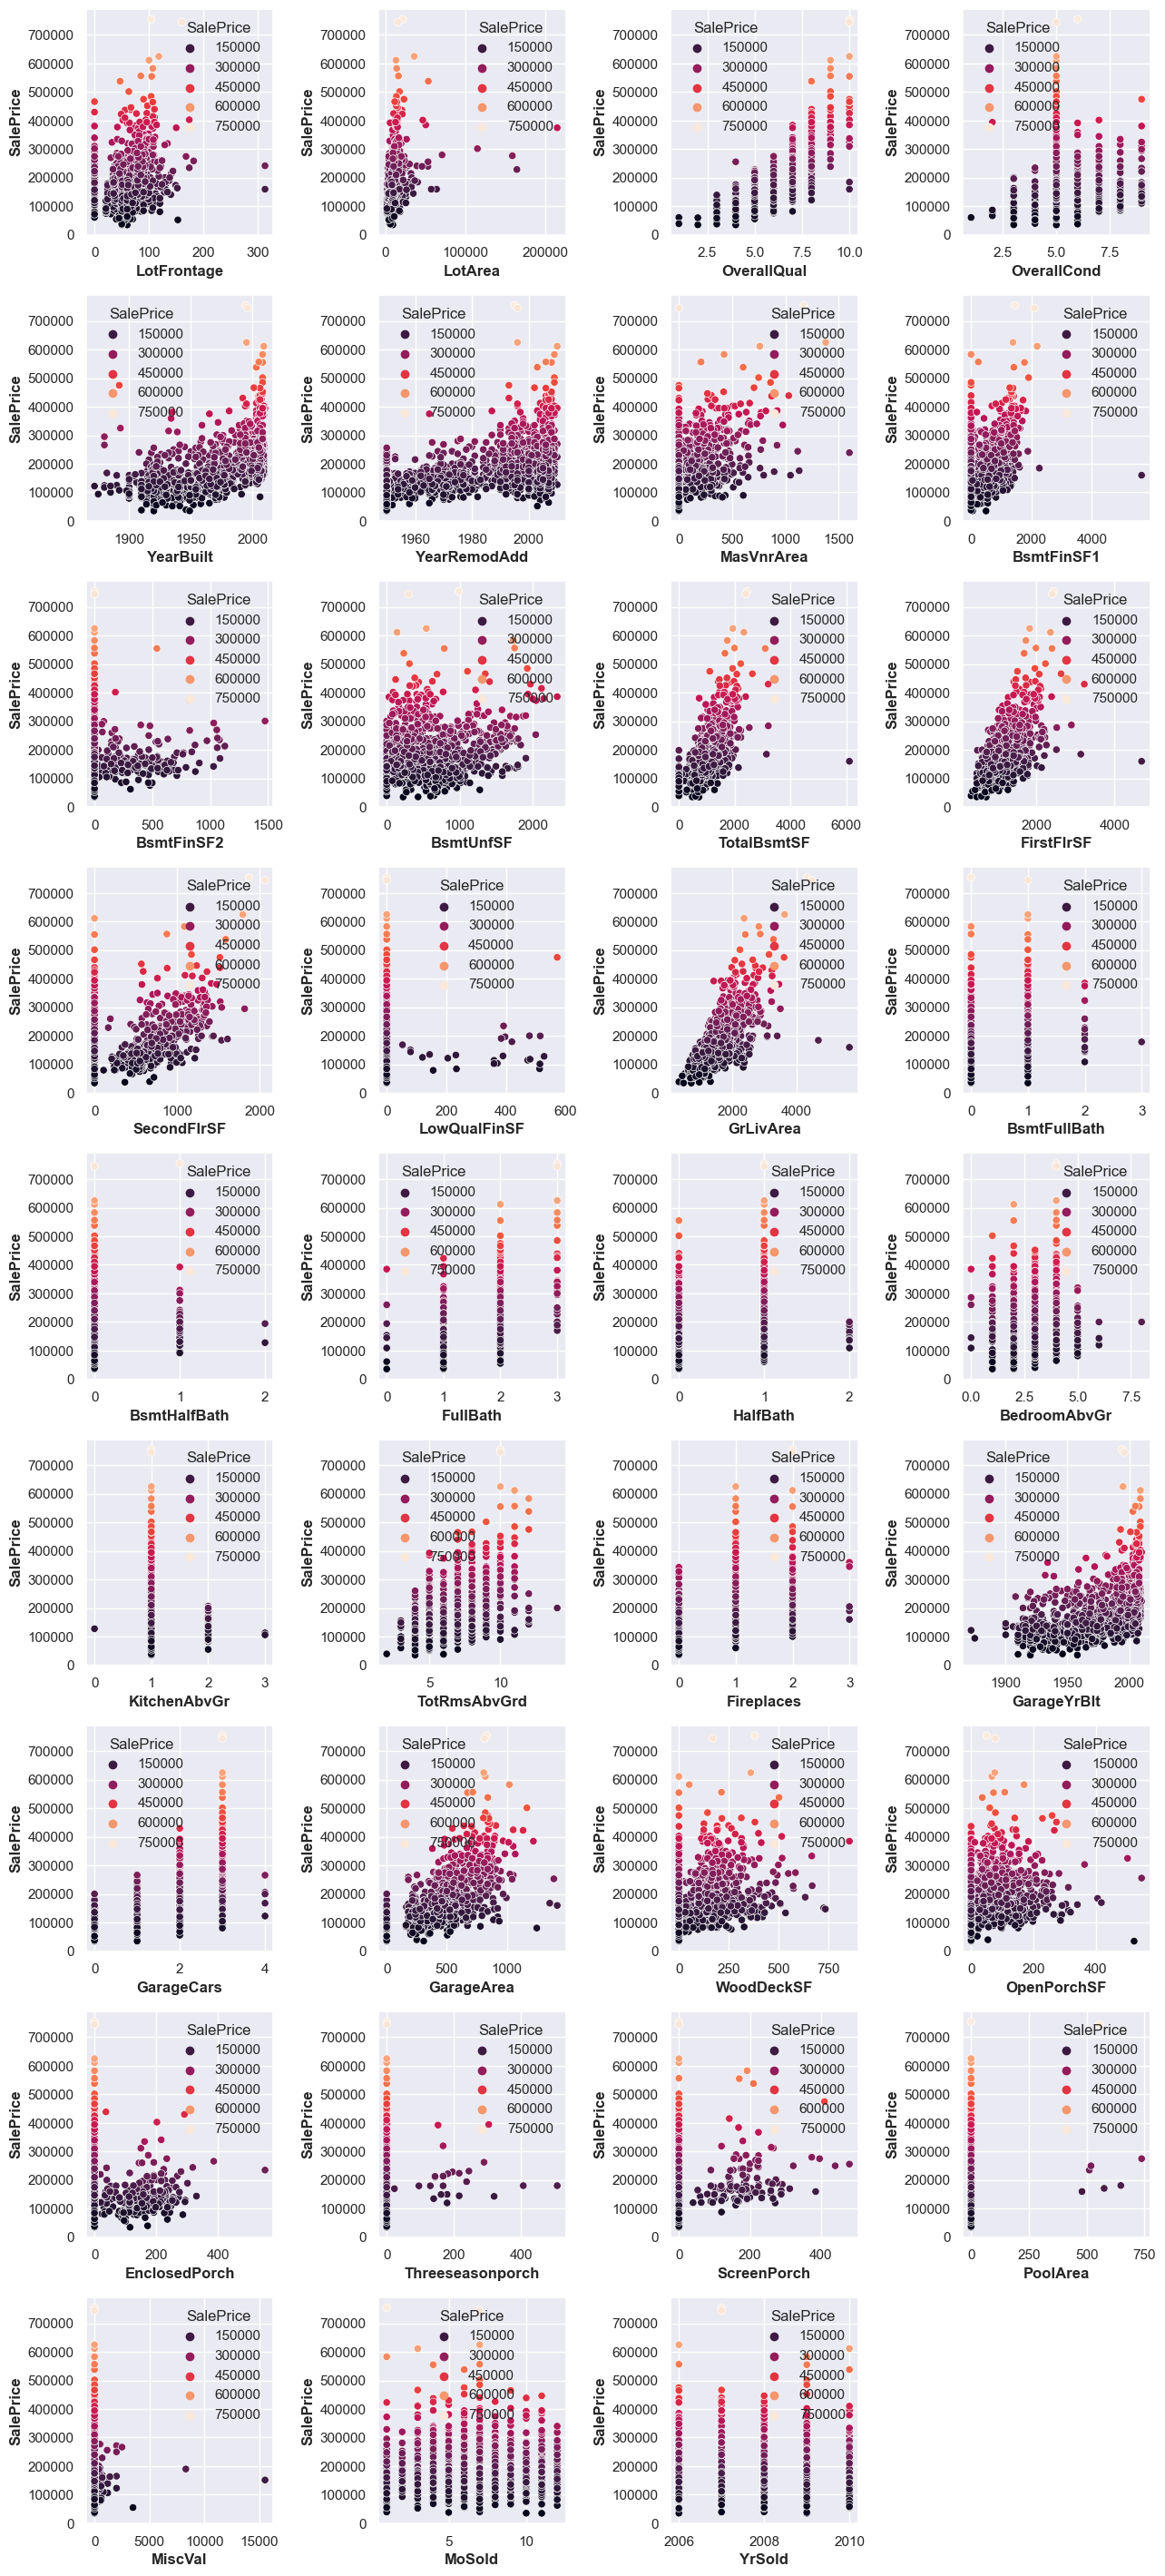

In [18]:
fig, axs = plt.subplots(figsize=(13, 110))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features), 4, i)
    sns.scatterplot(x=col, y='SalePrice', hue='SalePrice', palette="rocket", data=train_data)

### Root Mean Squared Logaritmic Error (RMSLE)

In [19]:
# As the metric for loss is RMSLE, we need to log-transform y
def rmsle(X, y, model=XGBRegressor()):
    X = X.copy()
    X = pd.get_dummies(X, drop_first=True)
    score = -cross_val_score(model, X, np.log1p(y), cv=5, scoring="neg_mean_squared_error")
    score = score.mean()
    score = np.sqrt(score)
    return score

In [20]:
%%time

X = X_train.copy()
y = y_train.copy()

baseline_score = rmsle(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14230 RMSLE
CPU times: total: 8.25 s
Wall time: 4.64 s


This baseline score will help us to know the improvement of our predictions by further data processing and feature engineering. 

### Mutual Information Score

In [21]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes] 
    # defining all the integer (numeric) data types as discrete
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

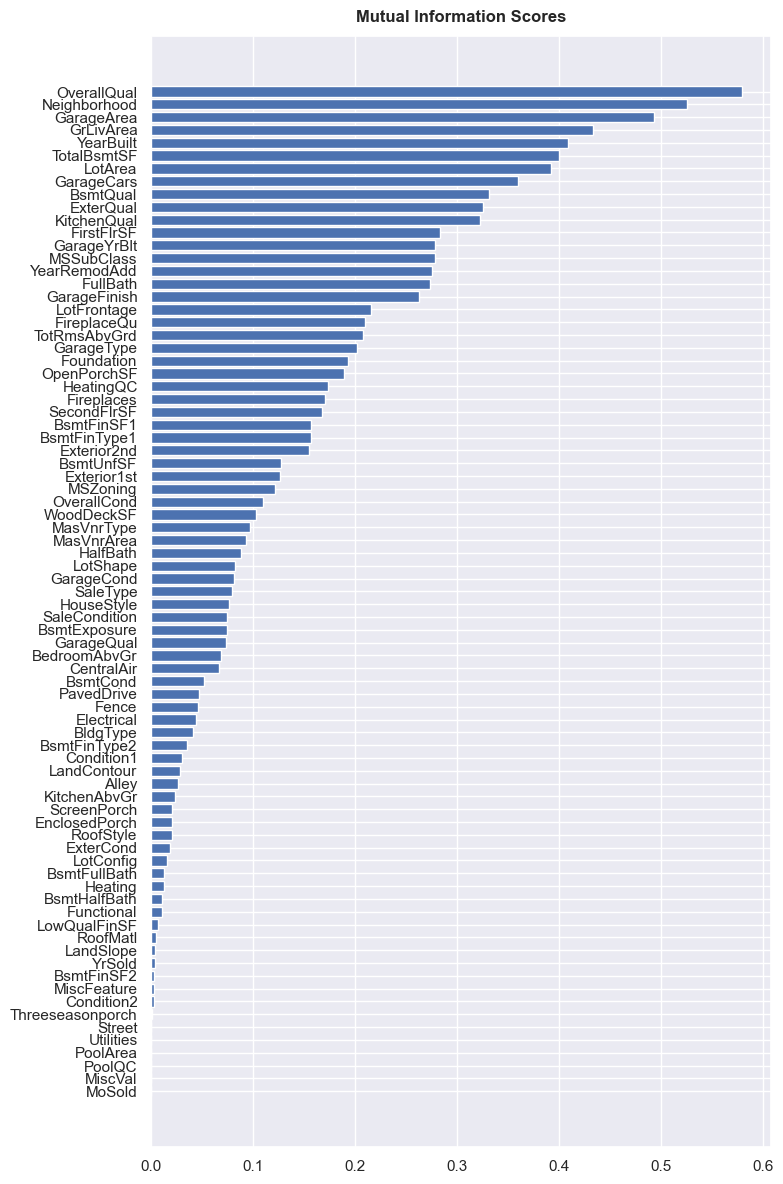

In [22]:
mi_scores = make_mi_scores(X, y) 
plt.figure(figsize=(8, 12))
plot_mi_scores(mi_scores)

The above plot gives us some insight on the mutual information between the target 'SalePrice' and the continuous and discrete features. 

# B: Feature Engineering
There are many kinds of features we can consider to introduce for this dataset e.g. mathmatical features, logarithmic features, interaction features, transform features and others. 

### Interaction features
Here we will briefly investigate the interactions between the features `GrLivArea`, `BldgType` and `Neighborhood`. While `GrLivArea` and `Neighborhood` scored highly in the MI scores, `BldgType` performed poorly. However, we should note that a feature (regardless has high or low MI score) can have interactions with other features and can thus be informative. It makes sense that the type of a dwelling and neighborhood should have effects on `GrLivArea` (Above ground living area) of the dwelling. We'll plot the variablitiy/trend of `SalePrice` for `GrLivArea` against different types of `BldgType` and `Neighborhood`. If there is significant variability in the `SalePrice` trend then there are interaction effects. We can include the interactions as new features in our model. 

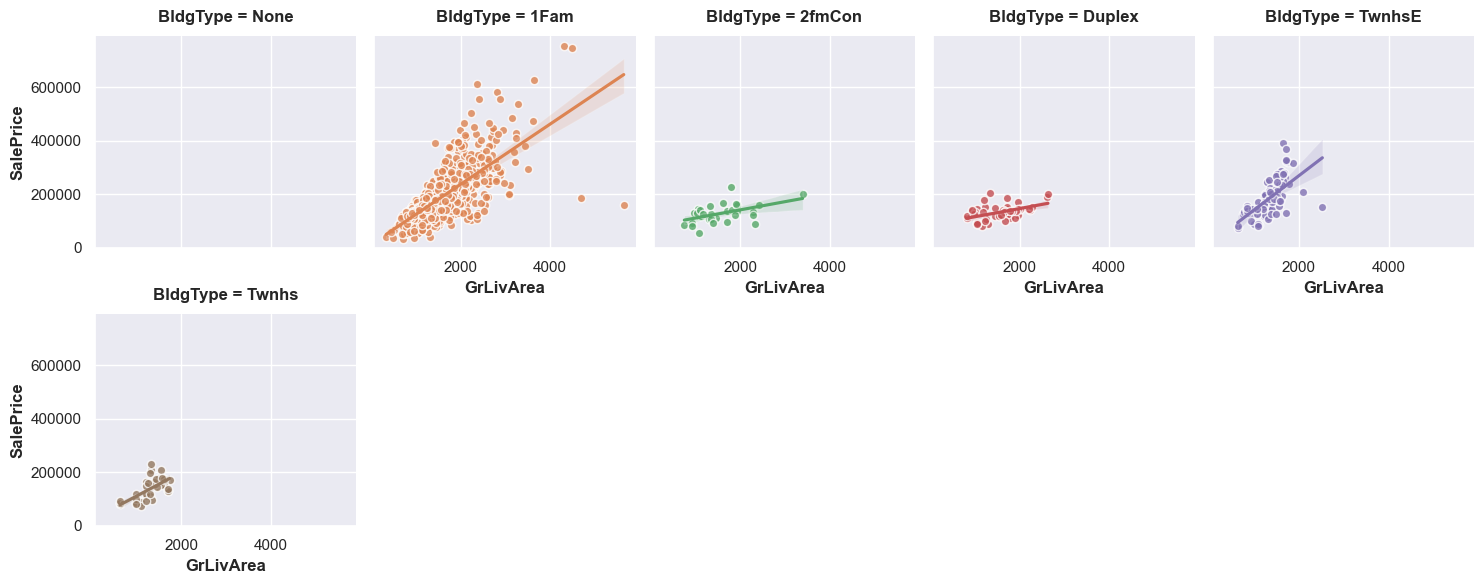

In [23]:
feature = "GrLivArea"

sns.lmplot(x=feature, y="SalePrice", hue="BldgType", col="BldgType",
           data=train_data, scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=3);
plt.tight_layout()
plt.show()

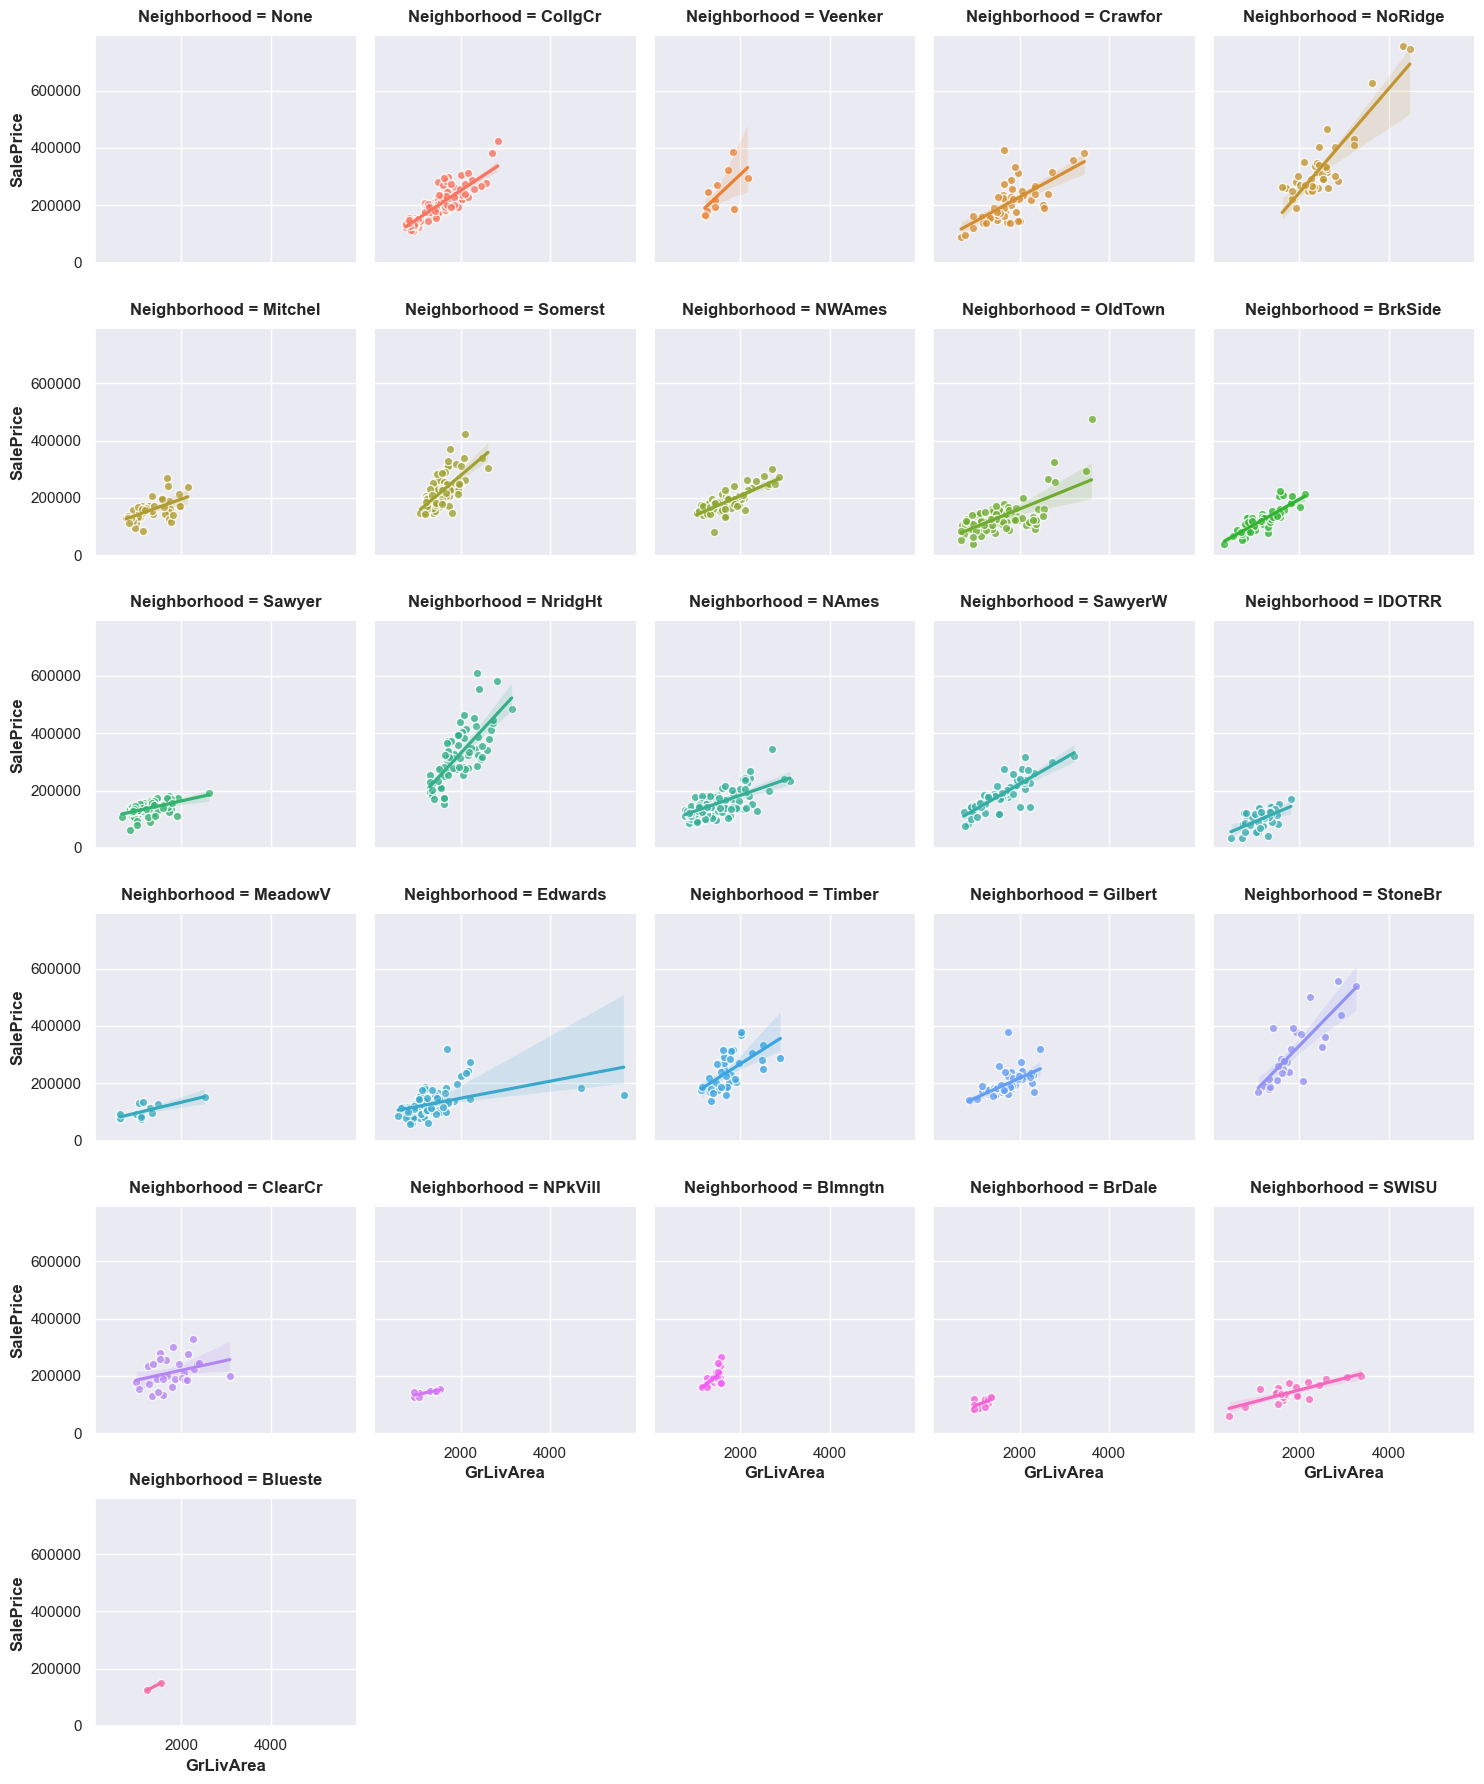

In [24]:
sns.lmplot(x=feature, y="SalePrice", hue="Neighborhood", col="Neighborhood",
           data=train_data, scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=3);
plt.show()

### Skewed features

Some features have skewed distribution. Converting them to log scale can help achieve normal distribution and act as new features. 

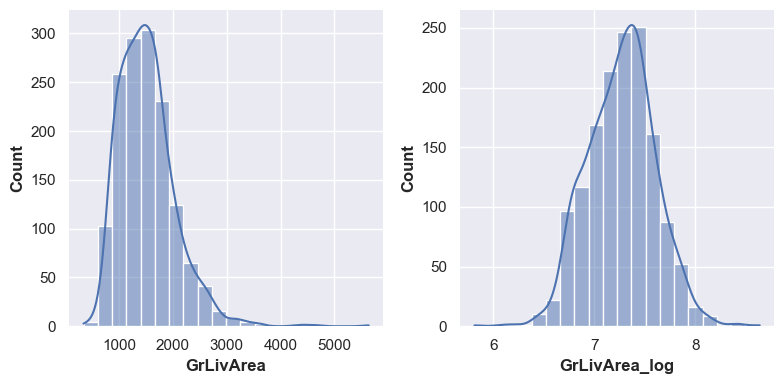

In [25]:
# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=False)
sns.despine(left=True, bottom=True)

# Plot histogram 
sns.histplot(train_data['GrLivArea'], kde=True, color="b", bins = 20, ax=axes[0])
sns.histplot(np.log1p(train_data['GrLivArea']), kde=True, color="b",  bins = 20, ax=axes[1])

axes[1].set_xlabel('GrLivArea_log')
plt.show()

### Create new features 

In [26]:
# Create features with pandas
def create_features_pandas(df):
    
    X = df.copy()
    
    # mathematical_transforms:
    X["LivLotRatio"] = X["GrLivArea"] / X["LotArea"]
    X["Spaciousness"] = (X["FirstFlrSF"] + X["SecondFlrSF"]) / X["TotRmsAbvGrd"]
    X['NewHouse_RecentRemodel'] = 2*(X['YearBuilt']/2010) + (X['YearRemodAdd'] - X['YearBuilt'])/2010 
                                  # check the plot for 'SAlePrice' vs 'YearBuilt' and 'YearRemodAdd' in section B
        
    X['TotalSF'] = X['TotalBsmtSF'] + X['FirstFlrSF'] + X['SecondFlrSF'] 
    X['TotalSF2'] = X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['FirstFlrSF'] + X['SecondFlrSF']
    X['TotalBathrooms'] = X['FullBath'] + (0.5*X['HalfBath']) + X['BsmtFullBath'] + (0.5*X['BsmtHalfBath'])
    X['TotalPorchArea'] = X['OpenPorchSF'] + X['Threeseasonporch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF']
    
    X["OverallGrade"] = np.sqrt(X["OverallQual"] * X["OverallCond"])
    X["GarageGrade"] = np.sqrt(X["GarageQual"] * X["GarageCond"])
    X["ExterGrade"] = np.sqrt(X["ExterQual"] * X["ExterCond"])
    
    # special features
    X['HasPool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)                                                                          
    X['Has2ndfloor'] = X['SecondFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasGarage'] = X['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    X['HasBasement'] = X['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasFireplace'] = X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    X["HasShed"] = (X["MiscFeature"] == "Shed") * 1 
    X["RemodelbeforeSold"] = (X["YearRemodAdd"] == X["YrSold"])*1  # True(1) if a remodelling happened in the same year the house was sold
    
    X.loc[X.Neighborhood == 'NridgHt', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'Crawfor', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'StoneBr', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'Somerst', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'NoRidge', "GoodNeighborhood"] = 1
    X["GoodNeighborhood"].fillna(0, inplace=True)

    X["AbnormalSaleCondition"] = X.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0}) 
    X["PartialSale"] = X.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1}) 
    X["GoodHeating"] = X.HeatingQC.replace({'Ex': 1, 'Gd': 1, 'TA': 0, 'Fa': 0, 'Po': 0})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', 'Threeseasonporch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea']
    X["TotalHouseArea"] = X[area_cols].sum(axis=1) 

    X["TotalArea1st2nd"] = X["FirstFlrSF"] + X["SecondFlrSF"]
    X["HouseAge"] = 2010 - X["YearBuilt"]
    X['SoldAge'] = X.YrSold - X.YearBuilt
       
    neighborhood = {"MeadowV" : 0,  "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, 
                    "Blueste" : 1, "SWISU" : 2, "NAmes" : 2,  "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, 
                    "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 2, "Somerst" : 3, 
                    "Timber" : 3, "StoneBr" : 3, "NridgHt" : 3, "NoRidge" : 4}

    X["NeighborhoodMap"] = X["Neighborhood"].map(neighborhood)
    

    # logarithmic features from highly skewed features
    X["GrLivArea_log"] = np.log1p(X.GrLivArea)
    X['MasVnrArea_log'] = np.log1p(X.MasVnrArea)


    # interaction features
    X1 = pd.get_dummies(X.BldgType, prefix="BldgType_Interaction")
    X1 = X1.mul(X.GrLivArea, axis=0)
    
    X2 = pd.get_dummies(X.Neighborhood, prefix="Neighborhood_Interaction")
    X2 = X2.mul(X.GrLivArea, axis=0)
    
    X = pd.concat([X, X1], axis=1)
    X = pd.concat([X, X2], axis=1)
    
    # counts features
    X["PorchTypes"] = X[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)


    # group_transforms features
    X["MedNhbdArea"] = X.groupby("Neighborhood")["GrLivArea"].transform("median")
  
    return X

X_train = create_features_pandas(X_train)

In [27]:
X = X_train.copy()
y = y_train.copy()

score = rmsle(X, y)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13508 RMSLE


In [28]:
print(X_train.shape)

(1460, 141)


# C. All preprocessing steps, model training and predictions

### Train and test data

In [29]:
X_train = train.copy()
y_train = X_train.pop("SalePrice")
X_test = test.copy()
print(X_train.shape)

(1460, 79)


### Re-define all data processing steps

In [30]:
# Renaming some features
# Feature names beginning with numbers are awkward to work with, so we rename them
def rename_columns(df):
    X = df.copy()
    # Names beginning with numbers are awkward to work with
    X.rename(columns={"1stFlrSF": "FirstFlrSF",
                       "2ndFlrSF": "SecondFlrSF",
                       "3SsnPorch": "Threeseasonporch"},
              inplace=True)
    
    return X

In [31]:
# Clean Data
def clean(df):
    X = df.copy()
    X["Exterior2nd"] = X["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them with the year the house was built
    X["GarageYrBlt"] = X["GarageYrBlt"].where(X.GarageYrBlt <= 2010, X.YearBuilt)
    
    # Some values of YrSold are also corrupt i.e. house was sold before it was built! We'll replace them with the year the house was built
    X["YrSold"] = X["YrSold"].where(X.YrSold >= X.YearBuilt, X.YearBuilt)
    
    return X

In [32]:
# The 'MSSubClass' is a string/unordered(nominal) categorical variable but encoded as `int` type. So we need to convert the data type. 
other_categorical_features = ['MSSubClass'] 

def numer_to_object(df):
    X = df.copy()
    for name in other_categorical_features:
        X[name] = X[name].astype('str')
    return X

In [33]:
# Handle Missing Values
def impute(df):
    X = df.copy()
    for name in X.select_dtypes("number"):
        X[name] = X[name].fillna(0)
    for name in X.select_dtypes("object"):
        X[name] = X[name].fillna("None") 
    return X

In [34]:
# Categorical features: ordianl encoding
# Some of the categorical features are ordered so we need to correctly encode them with specific orders

ordered_levels = {
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "PoolQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# add a new category 'None' in each ordinal categorical feature so that we can replace NAs with a category 'None'.
ordered_levels = {key: ["None"] + value for key, value in ordered_levels.items()} # the 1st level is 'None'

def ordinal_encode(df):
    X = df.copy()
    # Ordinal categories
    for name, levels in ordered_levels.items():
        X[name] = X[name].astype(CategoricalDtype(levels, ordered=True)) 
    return X

In [35]:
unordered_levels = {'MSSubClass': ['None', '60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80', '160', '75', '180', '40'], 
          'MSZoning': ['None', 'RL', 'RM', 'C (all)', 'FV', 'RH'], 
          'Street': ['None', 'Pave', 'Grvl'], 
          'Alley': ['None', 'Grvl', 'Pave'], 
          'LandContour': ['None', 'Lvl', 'Bnk', 'Low', 'HLS'], 
          'LotConfig': ['None', 'Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], 
          'Neighborhood': ['None', 'CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst', 'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes', 'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert', 'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste'], 
          'Condition1': ['None', 'Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe'], 
          'Condition2': ['None', 'Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'], 
          'BldgType': ['None', '1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], 
          'HouseStyle': ['None', '2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin'], 
          'RoofStyle': ['None', 'Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], 
          'RoofMatl': ['None', 'CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv', 'Roll', 'ClyTile'], 
          'Exterior1st': ['None', 'VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing', 'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn', 'Stone', 'ImStucc', 'CBlock'], 
          'Exterior2nd': ['None', 'VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng', 'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'BrkComm', 'ImStucc', 'AsphShn', 'Stone', 'Other', 'CBlock'], 
          'MasVnrType': ['BrkFace', 'None', 'Stone', 'BrkCmn'], 
          'Foundation': ['None', 'PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], 
          'Heating': ['None', 'GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], 
          'GarageType': ['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'None', 'Basment', '2Types'], 
          'MiscFeature': ['None', 'Shed', 'Gar2', 'Othr', 'TenC'], 
          'SaleType': ['None', 'WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'], 
          'SaleCondition': ['None', 'Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family']}

def nominal_encode(df):
    X = df.copy()
    # Ordinal categories
    for name, levels in unordered_levels.items():
        X[name] = X[name].astype(CategoricalDtype(levels, ordered=False))
    return X

In [36]:
# Factorize ordered categorical features with label encoding
def label_encode(df):
    X = df.copy()
    # The `cat.codes` attribute holds the category levels.
    for colname in X.select_dtypes(["category"]).columns:
        if X[colname].cat.ordered:  # Check if the categorical column is ordered
            X[colname] = X[colname].cat.codes
    return X

In [37]:
# Create features with pandas
def create_features_pandas(df):
    
    X = df.copy()
    
    # mathematical_transforms:
    X["LivLotRatio"] = X["GrLivArea"] / X["LotArea"]
    X["Spaciousness"] = (X["FirstFlrSF"] + X["SecondFlrSF"]) / X["TotRmsAbvGrd"]
    X['NewHouse_RecentRemodel'] = 2*(X['YearBuilt']/2010) + (X['YearRemodAdd'] - X['YearBuilt'])/2010 
                                  # check the plot for 'SAlePrice' vs 'YearBuilt' and 'YearRemodAdd' in section B
        
    X['TotalSF'] = X['TotalBsmtSF'] + X['FirstFlrSF'] + X['SecondFlrSF'] 
    X['TotalSF2'] = X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['FirstFlrSF'] + X['SecondFlrSF']
    X['TotalBathrooms'] = X['FullBath'] + (0.5*X['HalfBath']) + X['BsmtFullBath'] + (0.5*X['BsmtHalfBath'])
    X['TotalPorchArea'] = X['OpenPorchSF'] + X['Threeseasonporch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF']
    
    X["OverallGrade"] = np.sqrt(X["OverallQual"] * X["OverallCond"])
    X["GarageGrade"] = np.sqrt(X["GarageQual"] * X["GarageCond"])
    X["ExterGrade"] = np.sqrt(X["ExterQual"] * X["ExterCond"])
    
    # special features
    X['HasPool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)                                                                          
    X['Has2ndfloor'] = X['SecondFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasGarage'] = X['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    X['HasBasement'] = X['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasFireplace'] = X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    X["HasShed"] = (X["MiscFeature"] == "Shed") * 1 
    X["RemodelbeforeSold"] = (X["YearRemodAdd"] == X["YrSold"])*1  # True(1) if a remodelling happened in the same year the house was sold
    
    X.loc[X.Neighborhood == 'NridgHt', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'Crawfor', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'StoneBr', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'Somerst', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'NoRidge', "GoodNeighborhood"] = 1
    X["GoodNeighborhood"].fillna(0, inplace=True)

    X["AbnormalSaleCondition"] = X.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0}) 
    X["PartialSale"] = X.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1}) 
    X["GoodHeating"] = X.HeatingQC.replace({'Ex': 1, 'Gd': 1, 'TA': 0, 'Fa': 0, 'Po': 0})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', 'Threeseasonporch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea']
    X["TotalHouseArea"] = X[area_cols].sum(axis=1) 

    X["TotalArea1st2nd"] = X["FirstFlrSF"] + X["SecondFlrSF"]
    X["HouseAge"] = 2010 - X["YearBuilt"]
    X['SoldAge'] = X.YrSold - X.YearBuilt
       
    neighborhood = {"MeadowV" : 0,  "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, 
                    "Blueste" : 1, "SWISU" : 2, "NAmes" : 2,  "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, 
                    "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 2, "Somerst" : 3, 
                    "Timber" : 3, "StoneBr" : 3, "NridgHt" : 3, "NoRidge" : 4}

    X["NeighborhoodMap"] = X["Neighborhood"].map(neighborhood)
    

    # logarithmic features from highly skewed features
    X["GrLivArea_log"] = np.log1p(X.GrLivArea)
    X['MasVnrArea_log'] = np.log1p(X.MasVnrArea)


    # interaction features
    X1 = pd.get_dummies(X.BldgType, prefix="BldgType_Interaction")
    X1 = X1.mul(X.GrLivArea, axis=0)
    
    X2 = pd.get_dummies(X.Neighborhood, prefix="Neighborhood_Interaction")
    X2 = X2.mul(X.GrLivArea, axis=0)
    
    X = pd.concat([X, X1], axis=1)
    X = pd.concat([X, X2], axis=1)
    
    # counts features
    X["PorchTypes"] = X[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)


    # group_transforms features
    X["MedNhbdArea"] = X.groupby("Neighborhood")["GrLivArea"].transform("median")
  
    return X

### Combine all data processing steps 

In [38]:
def preprocess(df):
    
    X = df.copy()
    
    # rename columns
    X = rename_columns(X)
    
    # clean X
    X = clean(X)
    
    # nominal (unordered categorical) encode X
    X = numer_to_object(X)
    
    # impute NAs
    X = impute(X)
    
    # ordinal (ordered categorical) encode X
    X = ordinal_encode(X)
    
    # nominal (unordered categorical) encode X
    X = nominal_encode(X)
    
    # factorize ordered categorical features
    X = label_encode(X)
    
    # create features with pandas
    X = create_features_pandas(X)
    
    return X

In [39]:
X_train = preprocess(X_train)
print(X_train.shape)

(1460, 141)


In [40]:
X_test = preprocess(X_test)
print(X_test.shape)

(1459, 141)


### XGB Regressor

In [41]:
# XGB Regressor
xgb_params = dict(max_depth= 4,
                  learning_rate= 0.005005070416155941,
                  n_estimators= 7650,
                  min_child_weight= 2,
                  colsample_bytree= 0.20263034530849983,
                  subsample= 0.4402289758648288,
                  reg_alpha= 0.0010309970136600966,
                  reg_lambda= 0.012884368300273313,
                  random_state=1)
                  

xgb =  XGBRegressor(**xgb_params)

### ElasticNet

In [42]:
elasticnet = ElasticNet(max_iter=1000,
                        alpha=0.0007,
                        l1_ratio=0.9,
                        random_state=1)

### Create Stacking model for improved prediction
Stacking is an ensemble machine learning technique in which the outputs of multiple different machine learning models (base models) are fed into a higher-level meta-model to make the final output. Stacking can be useful to improve the overall accuracy of the predictions by utilising the strengths of each individual base model and minimising the effects of overfitting. 

In [43]:
base_models = [
    ('elasticnet', elasticnet),
    ('xgb', xgb)
]

meta_model = LinearRegression()

stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv = 5)

### Pipeline

In [44]:
# scaler for numeric features
scaler = RobustScaler()

# one-hot encoding for nominal categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

numeric_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(exclude=['number']).columns

column_transformer = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_cols),
        ('cat', ohe, categorical_cols)
    ],
    remainder = 'drop'
)

# Stacking model
stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Full pipeline
pipeline = Pipeline(steps=[
    ('transform', column_transformer),
    ('stack', stack)
])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, np.log1p(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  Index(['LotFrontage', 'LotArea', 'LotShape', 'Utilities', 'LandSlope',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'Neighborhood_Interaction_Gilbert', 'Neighborhood_Interaction_StoneBr',
       'Neighborhood_Interaction_ClearCr', 'Neighborhood_Interaction...
                                                             interaction_constraints=None,
                                                             learning_rate=0.005005070416155941,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=2,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=7650,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=1, ...))],
                                   final_estimator=LinearRegression()))])

In [45]:
# As the y was log-transformed during fitting/training the model, we need to exp-transform the predictions
predictions = np.exp(pipeline.predict(X_test))
output = pd.DataFrame({'Id': test.index, 'SalePrice': predictions})
output.to_csv('Test_prediction.csv', index=False)
print(output.head())

     Id      SalePrice
0  1461  122049.111006
1  1462  161232.308927
2  1463  183938.678703
3  1464  196977.838038
4  1465  186395.967253


In [46]:
time_end = time.time()
print("Notebook run time: {:.0f} seconds".format(time_end - time_start))

Notebook run time: 269 seconds
